<a href="https://colab.research.google.com/github/SatoJin02/BDA_course25/blob/main/Ex07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: Download the dataset
import urllib.request
import pandas as pd
import numpy as np
import time, psutil, os
import matplotlib.pyplot as plt

url = "https://www.dropbox.com/s/wa8d1sujzlx56hh/ETL_DATA_new.csv?dl=1"
data_path = "/content/ETL_DATA_new.csv"

if not os.path.exists(data_path):
    urllib.request.urlretrieve(url, data_path)
print("Dataset downloaded:", data_path)

Dataset downloaded: /content/ETL_DATA_new.csv


In [2]:
# STEP 2: Preprocessing (replace abnormal values + impute missing data)
df = pd.read_csv(data_path)


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()


for col in numeric_cols:
    df[col] = df[col].mask(~df[col].between(0, 250), np.nan)


for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

print("Preprocessing complete. Shape:", df.shape)

Preprocessing complete. Shape: (46005, 1833)


In [3]:
# STEP 3: Save the preprocessed dataset as ETL_preprocessed.csv
preprocessed_path = "/content/ETL_preprocessed.csv"
df.to_csv(preprocessed_path, index=False, chunksize=10000)
print("Saved:", preprocessed_path)

Saved: /content/ETL_preprocessed.csv


In [4]:
# STEP 4: Reload the preprocessed dataset
df = pd.read_csv(preprocessed_path)
print("Re-loaded preprocessed dataset.")

Re-loaded preprocessed dataset.


In [5]:
# STEP 5: Data transformation
df_binary = df.copy()
for col in numeric_cols:
    df_binary[col] = np.where(df_binary[col] >= 35, 1, 0)

transactions = df_binary.apply(
    lambda row: ",".join(row.index[row.eq(1)]),
    axis=1
)

transaction_df = pd.DataFrame({
    "TransactionID": np.arange(len(transactions)),
    "Items": transactions
})

In [6]:
# STEP 6: Save the transformed dataset
transaction_path = "/content/ETL_transactional.csv"
transaction_df.to_csv(transaction_path, index=False)
print("Saved transactional dataset:", transaction_path)

Saved transactional dataset: /content/ETL_transactional.csv


In [7]:
# STEP 7: Reload the transformed dataset
transaction_df = pd.read_csv(transaction_path)
print("Transactional data reloaded. Shape:", transaction_df.shape)

Transactional data reloaded. Shape: (46005, 2)


In [8]:
# STEP 8: Install the PAMI library (for Apriori implementation)
!pip install git+https://github.com/UdayLab/PAMI.git

  Cloning https://github.com/UdayLab/PAMI.git to /tmp/pip-req-build-9e62bnkd
  Running command git clone --filter=blob:none --quiet https://github.com/UdayLab/PAMI.git /tmp/pip-req-build-9e62bnkd
  Resolved https://github.com/UdayLab/PAMI.git to commit 2e868570b1349645db234cd62a1f0c8cc1db9a12
  Preparing metadata (setup.py) ... done


In [9]:
# STEP 9: Import Apriori class from the correct package
from PAMI.frequentPattern.basic import Apriori as alg

tx = pd.read_csv("/content/ETL_transactional.csv")

def to_tsv(items):
    if pd.isna(items) or not isinstance(items, str):
        return ""
    toks = [t.strip() for t in items.split(",") if t.strip()]
    return "\t".join(toks)

lines = tx["Items"].fillna("").map(to_tsv)
lines.to_csv("/content/transactions.tsv", index=False, header=False)
print("transactions.tsv created successfully.")

transactions.tsv created successfully.



▶ Running Apriori for minSup = 500
Frequent patterns were generated successfully using Apriori algorithm 
minSup=500 | Patterns=1195 | Runtime=6.241s | RSS=2186.1MB

▶ Running Apriori for minSup = 600
Frequent patterns were generated successfully using Apriori algorithm 
minSup=600 | Patterns=569 | Runtime=2.172s | RSS=2186.1MB

▶ Running Apriori for minSup = 700
Frequent patterns were generated successfully using Apriori algorithm 
minSup=700 | Patterns=349 | Runtime=1.788s | RSS=2186.1MB

▶ Running Apriori for minSup = 800
Frequent patterns were generated successfully using Apriori algorithm 
minSup=800 | Patterns=233 | Runtime=1.579s | RSS=2186.0MB

▶ Running Apriori for minSup = 900
Frequent patterns were generated successfully using Apriori algorithm 
minSup=900 | Patterns=167 | Runtime=1.893s | RSS=2186.0MB

▶ Running Apriori for minSup = 1000
Frequent patterns were generated successfully using Apriori algorithm 
minSup=1000 | Patterns=138 | Runtime=1.060s | RSS=2186.0MB


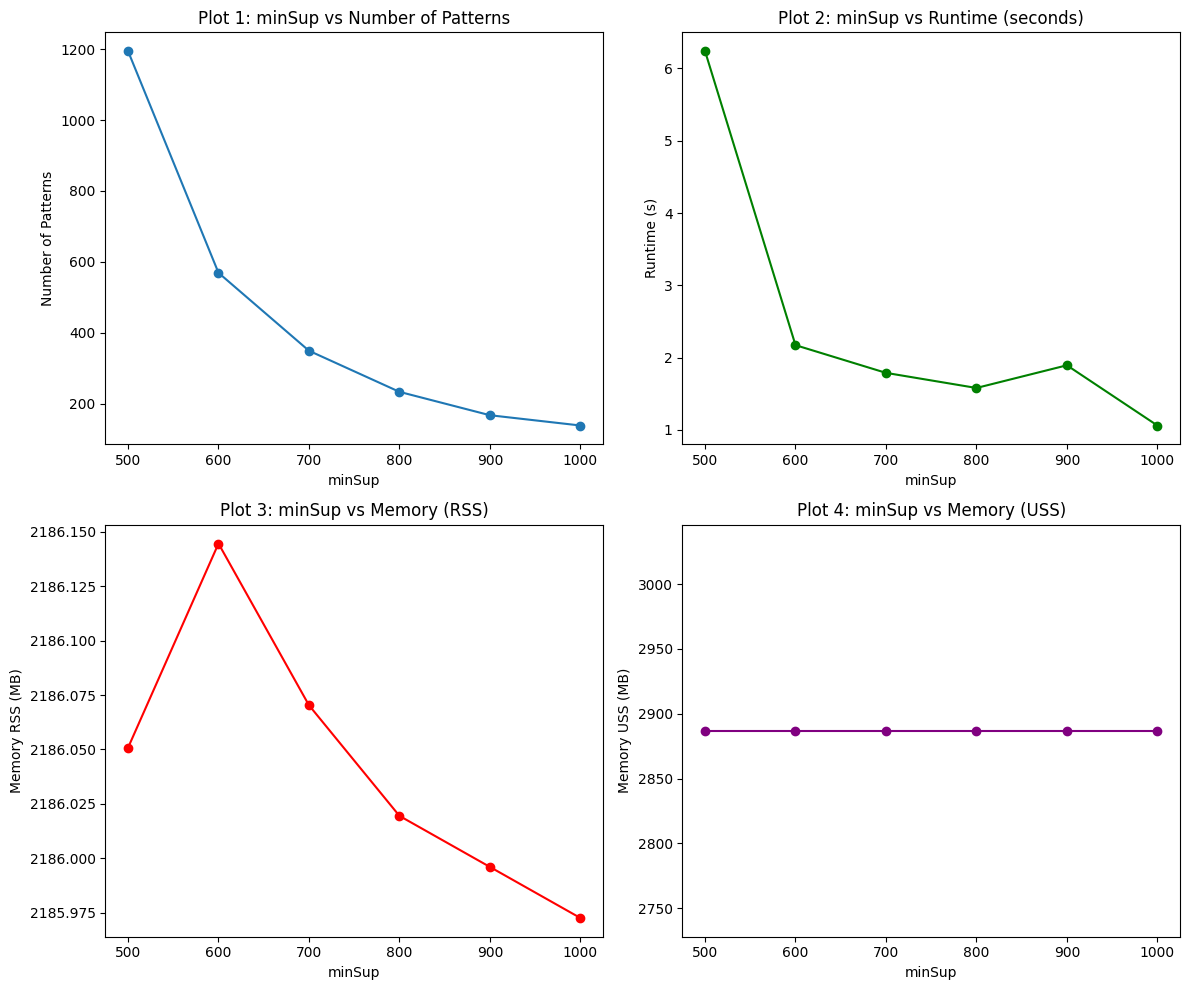


All Apriori runs completed successfully!


In [10]:
# STEP 10: Execute Apriori for multiple minSup values and collect metrics
min_sup_values = [500, 600, 700, 800, 900, 1000]
num_patterns, runtimes, rss_list, uss_list = [], [], [], []
process = psutil.Process(os.getpid())

for sup in min_sup_values:
    print(f"\n▶ Running Apriori for minSup = {sup}")
    t0 = time.time()

    obj = alg.Apriori(iFile="/content/transactions.tsv", minSup=sup, sep='\t')
    obj.mine()

    runtime = time.time() - t0
    df_patterns = obj.getPatternsAsDataFrame()

    mem_info = process.memory_info()
    rss = mem_info.rss / (1024 ** 2)
    uss = getattr(mem_info, "vms", 0) / (1024 ** 2)

    num_patterns.append(len(df_patterns))
    runtimes.append(runtime)
    rss_list.append(rss)
    uss_list.append(uss)

    print(f"minSup={sup} | Patterns={len(df_patterns)} | Runtime={runtime:.3f}s | RSS={rss:.1f}MB")

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(min_sup_values, num_patterns, marker='o')
plt.title("Plot 1: minSup vs Number of Patterns")
plt.xlabel("minSup")
plt.ylabel("Number of Patterns")

plt.subplot(2, 2, 2)
plt.plot(min_sup_values, runtimes, marker='o', color='green')
plt.title("Plot 2: minSup vs Runtime (seconds)")
plt.xlabel("minSup")
plt.ylabel("Runtime (s)")

plt.subplot(2, 2, 3)
plt.plot(min_sup_values, rss_list, marker='o', color='red')
plt.title("Plot 3: minSup vs Memory (RSS)")
plt.xlabel("minSup")
plt.ylabel("Memory RSS (MB)")

plt.subplot(2, 2, 4)
plt.plot(min_sup_values, uss_list, marker='o', color='purple')
plt.title("Plot 4: minSup vs Memory (USS)")
plt.xlabel("minSup")
plt.ylabel("Memory USS (MB)")

plt.tight_layout()
plt.show()

print("\nAll Apriori runs completed successfully!")